In the last blog post, we studied the time-evolution of a quantum wave packet in a harmonic potential.
Now, we want to take a look at a wave packet in an anharmonic oscillator.

In [1]:
import numpy as np
from scipy import integrate, sparse
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Video
import sympy as sp

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

As an example of an anharmonic oscillator we will use the Morse Potential:

$$
V(r) = D_e ( 1-e^{-a(r-r_e)} )^2
$$

which can be used as an approximate "interatomic interaction model for the potential energy of a diatomic molecule."  (Source: https://en.wikipedia.org/wiki/Morse_potential)

Let's define it in `sympy`:

In [4]:
r_s, De_s, re_s, a_s = sp.symbols('r D_e r_e a')

V_morse_s = De_s * ( 1 - sp.exp(-a_s*(r_s - re_s)))**2
V_morse_s

D_e*(1 - exp(-a*(r - r_e)))**2

Using the first and second derivative for the harmonic approximation around $r_e$:

In [5]:
dr_V_morse_s = sp.diff(V_morse_s, r_s)
dr2_V_morse_s = sp.diff(dr_V_morse_s, r_s)
V_harm_s = V_morse_s.subs(r_s, re_s) + dr_V_morse_s.subs(r_s, re_s) * (r_s - re_s) + sp.Rational(1, 2) * dr2_V_morse_s.subs(r_s, re_s) * (r_s - re_s)**2
V_harm_s

D_e*a**2*(r - r_e)**2

And with `lambdify` we can convert these expressiona to a python functions and plot them:

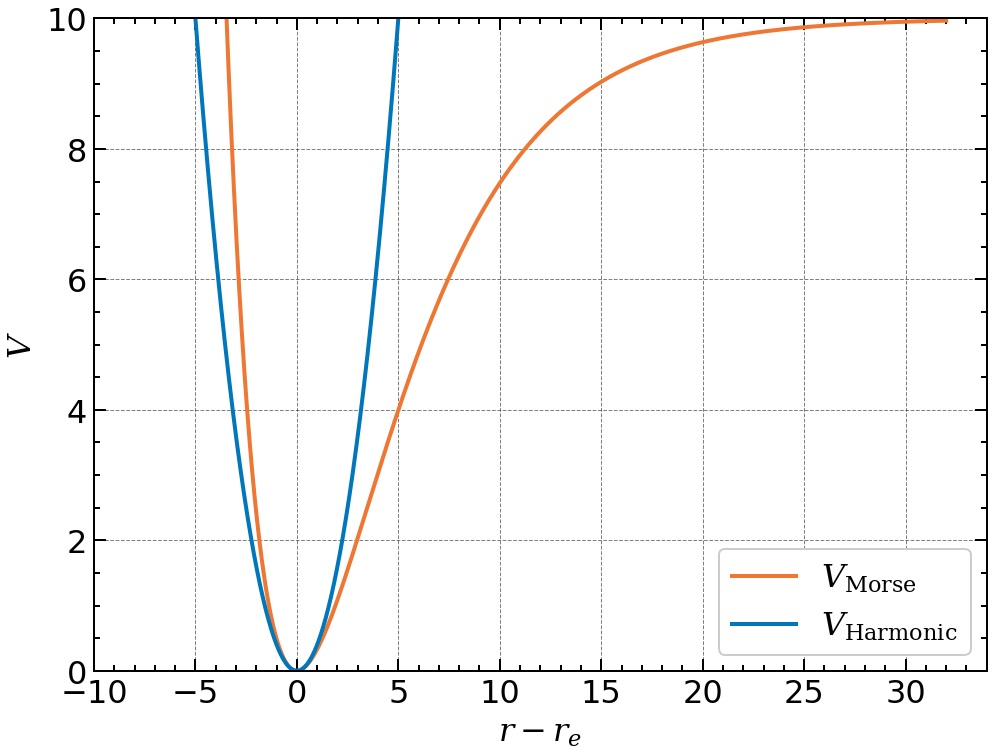

In [6]:
V_morse_f = sp.lambdify([r_s, re_s, De_s, a_s], V_morse_s)
V_harm_f = sp.lambdify([r_s, re_s, De_s, a_s], V_harm_s)

L = 40
N = L*100 + 1
# x = r - re
x = np.linspace(0, L, N)  - L/5

De = 10
a = 0.2
mass = 1
hbar = 1

plt.figure(figsize=(8,6))
plt.plot(x, V_morse_f(x, 0, De, a), label=r"$V_\mathrm{Morse}$")
plt.plot(x, V_harm_f(x, 0, De, a), label=r"$V_\mathrm{Harmonic}$")
plt.xlabel('$r - r_e$')
plt.ylabel('$V$')
plt.ylim(0, De)
plt.legend();

The Morse potenial is limited to $D_e$ for large $r$. This is the dissociation energy and a particle in the Morse potential is not bounded for energies $E > D_e$.

# Classical mechanics

The newtonian equation of motion for a positon $x(t)$ of particle of mass $m$ in a potential $V(x)$ is:

$$
\frac{d^2}{dt^2} x = - \frac{1}{m}\frac{d}{dx} V(x)
$$

We will integrate this with $x(0)=0$ and three different initial momenta $p(0) \in \{1.5, 2.5, 3.5\}$.

In [7]:
F_f = sp.lambdify([r_s, re_s, De_s, a_s], -dr_V_morse_s)

t_eval = np.linspace(0, 30, 601)

def ds_dt(t, s):
    x, p = s
    dx_dt = p / mass
    dp_dt = F_f(x, 0, De, a)/mass
    return np.array([dx_dt, dp_dt])

sol_cl1 = integrate.solve_ivp(ds_dt, t_span = [t_eval[0], t_eval[-1]], y0 = [0.0, 3.5], t_eval = t_eval, method="RK23")
sol_cl2 = integrate.solve_ivp(ds_dt, t_span = [t_eval[0], t_eval[-1]], y0 = [0.0, 2.5], t_eval = t_eval, method="RK23")
sol_cl3 = integrate.solve_ivp(ds_dt, t_span = [t_eval[0], t_eval[-1]], y0 = [0.0, 1.5], t_eval = t_eval, method="RK23")

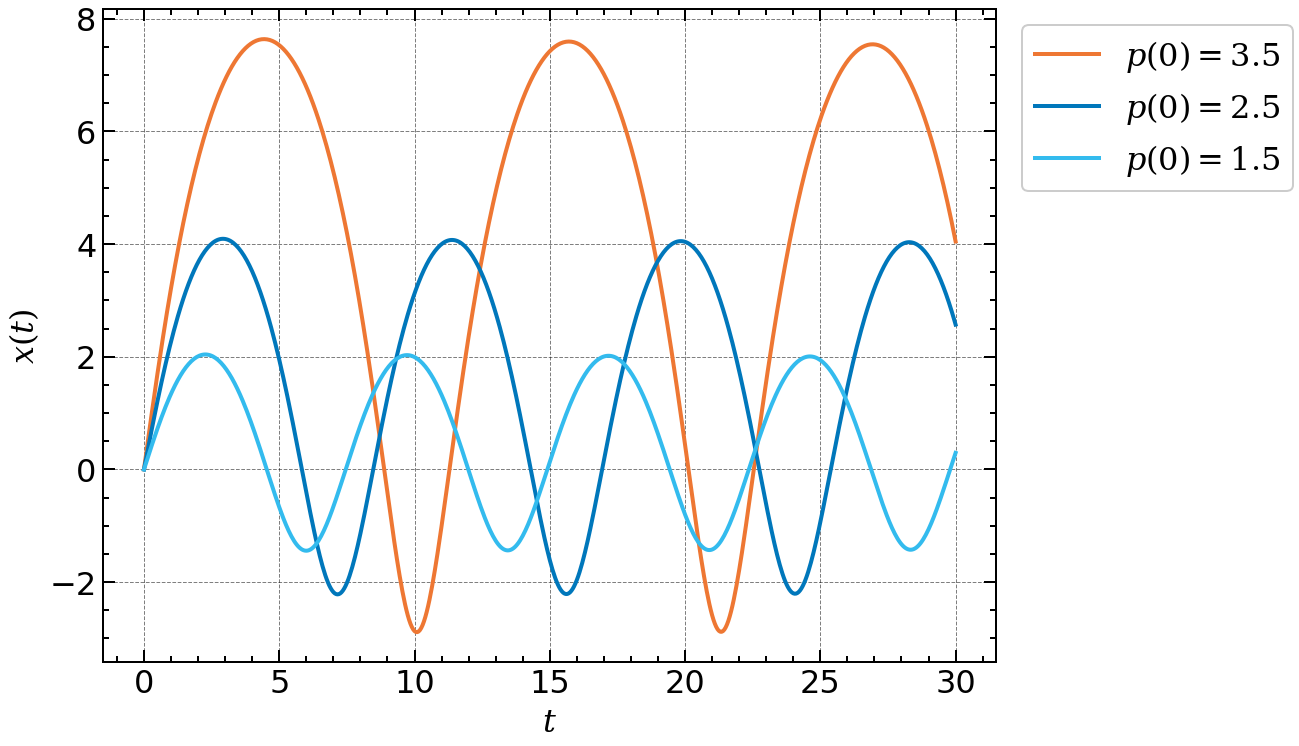

In [8]:
plt.figure(figsize=(8,6))
plt.plot(t_eval, sol_cl1.y[0,:], label="$p(0)=3.5$")
plt.plot(t_eval, sol_cl2.y[0,:], label="$p(0)=2.5$")
plt.plot(t_eval, sol_cl3.y[0,:], label="$p(0)=1.5$")
plt.ylabel('$x(t)$')
plt.xlabel('$t$')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0));

The trajectory with the smallest initial momentum, $p(0)=1.5$, resembles a harmonic oscillator the most, because
for small amplitudes the harmonic approximation around the minimum is valid. But the higher the initial momentum 
gets the more the deviations from the harmonic movement become apparent. We can also see, that the frequency of 
the oscillation gets larger with higher amplitudes.

# Quantum Mechanics

Now let's move to quantum mechanics!

First define the Hamiltonian:

In [9]:
# The second order derivative D2:
dx = np.diff(x)[0]
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

V = sparse.diags([V_morse_f(x, 0, De, a)], [0]) 
T = -(hbar**2 / (2 * mass)) * D2

# The Hamiltonian
H = T + V

And now, once again, find the eigenbasis (with the smallest eigenvalues) and the ground state:

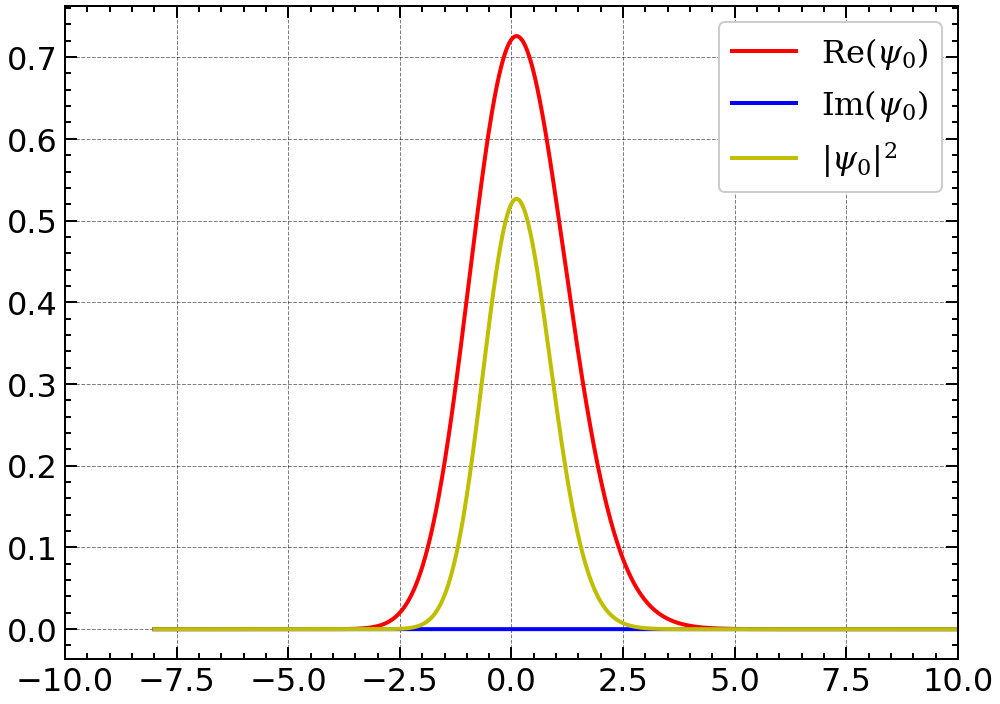

In [10]:
eigs, eigv = sparse.linalg.eigsh(H, k=20, which='SM')
# Test if all eigenvals are real (as expected)
assert all(np.isreal(eigs))

# Make complex normalized basis
basis = eigv.astype(complex)
basis /= np.sqrt(np.sum(np.abs(basis)**2, axis=0)*dx)  # norm the vector 

psi0 = basis.T[0]
psi0.real = np.abs(psi0.real) # for plot in the upper half

# Plot the ground state
plt.figure(figsize=(8,6))
plt.plot(x, psi0.real, 'r', label='$\mathrm{Re}(\psi_0)$')
plt.plot(x, psi0.imag, 'b', label='$\mathrm{Im}(\psi_0)$')
plt.plot(x, np.abs(psi0)**2, 'y', label='$|\psi_0|^2$')
plt.xlim(-10, 10)
plt.legend();

To get a moving wave packet we will again use the
unitary boost operator from [last blog post](https://znswanderer.github.io/physics/Time-Evolution/):

In [11]:
def boost(dp):
    return sparse.diags([np.exp(1j * x * dp / hbar)], [0]) 

# Boosting some momentum units:
U_dp = boost(dp=2)
psi_dp = U_dp @ psi0

The boosted wave packet in the energy basis has the coefficients:

$$
a_n = \langle n | \psi_{\Delta p}\rangle
$$

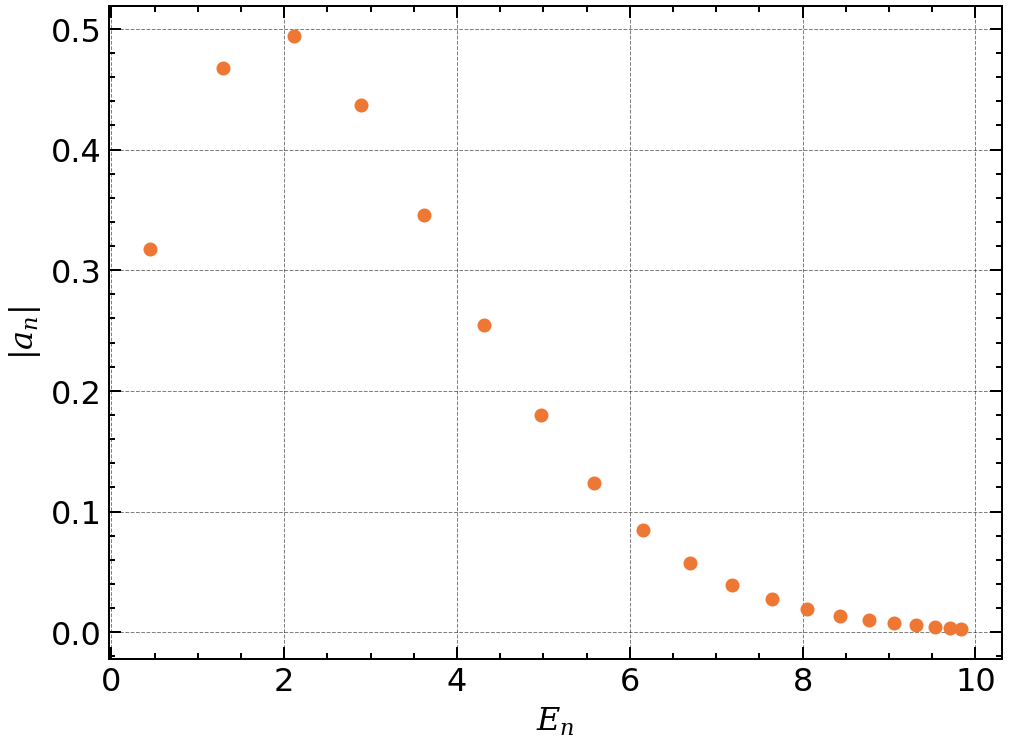

In [12]:
an = basis.conj().T @ psi_dp * dx
En = eigs

plt.figure(figsize=(8,6))
plt.plot(En, np.abs(an), 'o')
plt.xlabel("$E_n$")
plt.ylabel("$|a_n|$");

With this we can calculate $\psi_{\Delta p}(t)$ and get a time evolution

$$
| \psi (t)\rangle = \sum_n a_n e^{-i E_n t / \hbar} |n \rangle
$$

In [13]:
def psi_t(t):
    psi_t = np.sum(an * np.exp(-1j * En * t/ hbar) * basis, axis=1)
    return psi_t

t_eval = np.linspace(0, 100, 501)
sol2 = np.array([psi_t(t) for t in t_eval]).T

We use that for an animation: (The class `WaveAnimation` can be found in the notebook)

In [14]:
class WaveAnimation:
    def __init__(self, x_vec, psi_t, V_vec, t_vec, figsize=(6,4), ylim=(-1.5, 2)):
        self.x_vec = x_vec
        self.psi_t = psi_t
        self.V_vec = V_vec
        self.t_vec = t_vec
        self.fig = plt.figure(figsize=figsize)
        self.ax1 = ax1 = plt.subplot(1,1,1)
        ax1.set_xlim(x_vec[0], x_vec[-1])
        ax1.set_ylim(*ylim)
        self.title = ax1.set_title('')
        self.line1, = ax1.plot([], [], "k--")
        self.line1.set_linewidth(1)
        self.line4, = ax1.plot([], [], "y")
        
        # The position operator
        X = sparse.diags([x_vec], [0]) 
        def avg_pos(psi):
            return (psi.T.conj() @ (X.dot(psi))) * dx
        self.avg_x = [np.real(avg_pos(psi_t[:, i])) for i in range(len(t_vec))]
        
        self.axin1 = ax1.inset_axes([0.6, 0.5, 0.45, 0.45])
        self.axin1.xaxis.set_ticklabels([])
        self.axin1.yaxis.set_ticklabels([])
        self.inner_line1, = self.axin1.plot(t_vec, self.avg_x)
        self.inner_line1.set_linewidth(1)
        self.inner_point, = self.axin1.plot([], [], 'ro')
        
    def init_anmimation(self):
        self.line1.set_data(self.x_vec, self.V_vec)
        return self.line1,

    def get_frame(self, i):
        psi = self.psi_t[:, i]
        self.line4.set_data(self.x_vec, np.abs(psi)**2)
        self.title.set_text('Time = %1.1f' % self.t_vec[i])
        self.inner_point.set_data(self.t_vec[i], self.avg_x[i])
        return self.line1,
    
    def animation(self):
        anim = animation.FuncAnimation(self.fig, self.get_frame, init_func=self.init_anmimation,
                                       frames=len(self.t_vec), interval=50, blit=True)
        return anim
    
    def save_mp4(self, filename):
        ffwriter = animation.FFMpegWriter(fps=20, extra_args=['-vcodec', 'libx264'])
        anim = self.animation()
        anim.save(filename, dpi=300, writer=ffwriter)
        plt.close()   # to prevent the last frame from showing in notebook

In [15]:
anim = WaveAnimation(x, psi_t=sol2, V_vec=V_morse_f(x, 0, De, a)*0.2 , t_vec=t_eval)
anim.ax1.set_xlim(-5, 15)
anim.ax1.set_ylim(-0.1, 1)
anim.save_mp4('wave_eigs_morse.mp4')

Video('wave_eigs_morse.mp4', width=600)

In the animation we see in the large graph the evolution of $|\psi(t)|^2$ and in the inset 
the oscillation of the average position

$$
\langle \psi(t) | \hat x | \psi(t) \rangle
$$

is plotted and the current time $t$ is depicted by the moving red dot.

We can clearly see, that the average position follows the classical path only for a very short time.
After this short time, the wave function has a quite different shape compared to the initial wave packet
and the oscillation (meassured by the average position) seems to die out. However for still larger
times the oscillation seems to come back at least partly. For the harmonic oscillator the average position followed the classical path exactly, which
is described by the [Ehrenfest theorem](https://en.wikipedia.org/wiki/Ehrenfest_theorem).
But the Ehrenfest theorem is valid only when the potential is quadratic.

Without going into detail here, it is quite clear, that in the case of the harmonic oscillator
we have a periodic wave packet, because the frequencies of the energy eigenstates are all 
equidistant. For the Morse potential the eigenvalues are (according to Wikipedia):

$$
E_n = \hbar \omega_0 (n+1/2) - \frac{\left[\hbar\omega_0(n+1/2)\right]^2}{4D_e}
$$

which are clearly not equistant.